## LSTM Models Training

In [1]:
import pandas as pd

from config import *

In [2]:
df = pd.read_csv('WELFake_Dataset_processed.tsv', sep='\t')
df.head(2)

,id,title,text,label,full_text,full_text_processed
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1.0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,law enforcement high alert follow threat cop w...
1,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1.0,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,unbelievable obamas attorney general say charl...


In [3]:
from sklearn.model_selection import train_test_split

train_texts, temp_text, train_labels, temp_labels = train_test_split(
  df['full_text_processed'],
  df['label'],
  random_state=2018,
  test_size=0.4,
  stratify=df['label']
)
val_texts, test_texts, val_labels, test_labels = train_test_split(
  temp_text,
  temp_labels,
  random_state=2018,
  test_size=0.5,
  stratify=temp_labels
)

### Gensim Word2Vec initialization

In [4]:
import gensim
from Training.utils import make_words, train_evaluate_and_test_models

mod = gensim.models.Word2Vec(sentences=make_words(df['full_text_processed']), vector_size=EMBEDDING_DIM, window=5, min_count=1, workers=5)

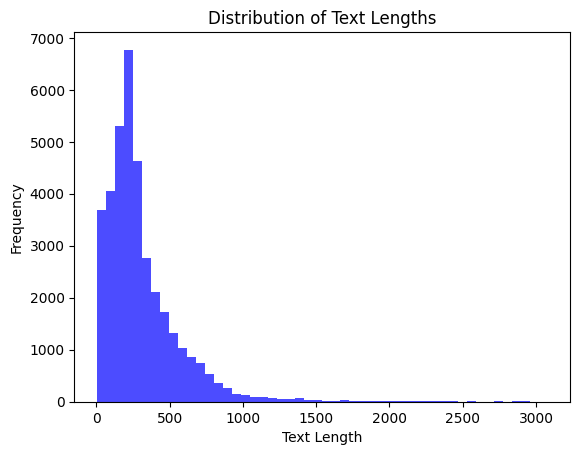

Mean Length: 309.46
Median Length: 239.00
90th Percentile: 623.00
Maximum Length: 3081.00


In [5]:
text_lengths = train_texts.apply(lambda x: len(str(x).split()))

import matplotlib.pyplot as plt
import numpy as np

plt.hist(text_lengths, bins=50, color='blue', alpha=0.7)
plt.xlabel("Text Length")
plt.ylabel("Frequency")
plt.title("Distribution of Text Lengths")
plt.show()

print(f"Mean Length: {np.mean(text_lengths):.2f}")
print(f"Median Length: {np.median(text_lengths):.2f}")
print(f"90th Percentile: {np.percentile(text_lengths, 90):.2f}")
print(f"Maximum Length: {np.max(text_lengths):.2f}")

In [6]:
from NewsDatasetLSTM import NewsDatasetLSTM
from torch.utils.data import DataLoader

max_len = 623 
# Instantiate datasets
train_dataset = NewsDatasetLSTM(train_texts, train_labels, mod, max_len=max_len)
val_dataset = NewsDatasetLSTM(val_texts, val_labels, mod, max_len=max_len)
test_dataset = NewsDatasetLSTM(test_texts, test_labels, mod, max_len=max_len)

# Create DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size,drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [7]:
num_negatives = len(df[df['label'] == 0])
num_positives = len(df[df['label'] == 1])
class_counts = [num_negatives, num_positives]

results = train_evaluate_and_test_models(class_counts,train_loader, val_loader, test_loader, epochs=10)


Training Model 1 (LSTM with Attention)


Evaluating: 100%|██████████| 193/193 [00:27<00:00,  7.01it/s]


Best checkpoint saved at checkpoints\LSTMWithAttention_best.pt
Epoch 1/10
 Train Loss: 0.5438
 Val Loss: 0.3752
 Val Accuracy: 0.8552
 Val F1 Score: 0.8395
 Precision: 0.8182
 Recall: 0.8619
 Val AUC-ROC: 0.9316



Evaluating: 100%|██████████| 193/193 [00:28<00:00,  6.71it/s]


Best checkpoint saved at checkpoints\LSTMWithAttention_best.pt
Epoch 2/10
 Train Loss: 0.3430
 Val Loss: 0.2411
 Val Accuracy: 0.9162
 Val F1 Score: 0.9062
 Precision: 0.8917
 Recall: 0.9211
 Val AUC-ROC: 0.9724



Evaluating: 100%|██████████| 193/193 [00:28<00:00,  6.83it/s]


Best checkpoint saved at checkpoints\LSTMWithAttention_best.pt
Epoch 3/10
 Train Loss: 0.2548
 Val Loss: 0.2066
 Val Accuracy: 0.9318
 Val F1 Score: 0.9231
 Precision: 0.9141
 Recall: 0.9322
 Val AUC-ROC: 0.9802



Evaluating: 100%|██████████| 193/193 [00:28<00:00,  6.80it/s]


Best checkpoint saved at checkpoints\LSTMWithAttention_best.pt
Epoch 4/10
 Train Loss: 0.2229
 Val Loss: 0.1876
 Val Accuracy: 0.9383
 Val F1 Score: 0.9311
 Precision: 0.9136
 Recall: 0.9493
 Val AUC-ROC: 0.9830



Evaluating: 100%|██████████| 193/193 [00:28<00:00,  6.73it/s]


Best checkpoint saved at checkpoints\LSTMWithAttention_best.pt
Epoch 5/10
 Train Loss: 0.2034
 Val Loss: 0.1727
 Val Accuracy: 0.9428
 Val F1 Score: 0.9363
 Precision: 0.9158
 Recall: 0.9578
 Val AUC-ROC: 0.9853



Evaluating: 100%|██████████| 193/193 [00:30<00:00,  6.33it/s]


Best checkpoint saved at checkpoints\LSTMWithAttention_best.pt
Epoch 6/10
 Train Loss: 0.1898
 Val Loss: 0.1602
 Val Accuracy: 0.9470
 Val F1 Score: 0.9409
 Precision: 0.9209
 Recall: 0.9618
 Val AUC-ROC: 0.9870



Evaluating: 100%|██████████| 193/193 [00:28<00:00,  6.82it/s]


Best checkpoint saved at checkpoints\LSTMWithAttention_best.pt
Epoch 7/10
 Train Loss: 0.1748
 Val Loss: 0.1585
 Val Accuracy: 0.9504
 Val F1 Score: 0.9442
 Precision: 0.9327
 Recall: 0.9559
 Val AUC-ROC: 0.9879



Evaluating: 100%|██████████| 193/193 [00:28<00:00,  6.78it/s]


Best checkpoint saved at checkpoints\LSTMWithAttention_best.pt
Epoch 8/10
 Train Loss: 0.1623
 Val Loss: 0.1511
 Val Accuracy: 0.9509
 Val F1 Score: 0.9454
 Precision: 0.9250
 Recall: 0.9666
 Val AUC-ROC: 0.9883



Evaluating: 100%|██████████| 193/193 [00:27<00:00,  6.98it/s]


Best checkpoint saved at checkpoints\LSTMWithAttention_best.pt
Epoch 9/10
 Train Loss: 0.1556
 Val Loss: 0.1431
 Val Accuracy: 0.9541
 Val F1 Score: 0.9485
 Precision: 0.9356
 Recall: 0.9617
 Val AUC-ROC: 0.9898



Evaluating: 100%|██████████| 193/193 [00:27<00:00,  6.97it/s]


Best checkpoint saved at checkpoints\LSTMWithAttention_best.pt
Epoch 10/10
 Train Loss: 0.1436
 Val Loss: 0.1410
 Val Accuracy: 0.9564
 Val F1 Score: 0.9507
 Precision: 0.9455
 Recall: 0.9559
 Val AUC-ROC: 0.9908


Saving final model state...
Final checkpoint saved at checkpoints\LSTMWithAttention_final.pt
Final model saved at: checkpoints\LSTMWithAttention_final.pt

Testing with best model checkpoint...
Checkpoint loaded from checkpoints\LSTMWithAttention_best.pt
Resuming from epoch 10


Evaluating: 100%|██████████| 194/194 [00:28<00:00,  6.86it/s]



Test Results:
Loss: 0.1500
Accuracy: 0.9514
F1 Score: 0.9450
Precision: 0.9393
Recall: 0.9507
ROC AUC: 0.9898


Training Model 2 (LSTM without Attention)


Evaluating: 100%|██████████| 193/193 [00:27<00:00,  6.96it/s]


Best checkpoint saved at checkpoints\LSTMWithoutAttention_best.pt
Epoch 1/10
 Train Loss: 0.7793
 Val Loss: 0.7713
 Val Accuracy: 0.4736
 Val F1 Score: 0.6167
 Precision: 0.4533
 Recall: 0.9642
 Val AUC-ROC: 0.5308



Evaluating: 100%|██████████| 193/193 [00:27<00:00,  6.98it/s]


Best checkpoint saved at checkpoints\LSTMWithoutAttention_best.pt
Epoch 2/10
 Train Loss: 0.7657
 Val Loss: 0.7656
 Val Accuracy: 0.4791
 Val F1 Score: 0.6204
 Precision: 0.4562
 Recall: 0.9692
 Val AUC-ROC: 0.6987



Evaluating: 100%|██████████| 193/193 [00:27<00:00,  7.07it/s]


Best checkpoint saved at checkpoints\LSTMWithoutAttention_best.pt
Epoch 3/10
 Train Loss: 0.7304
 Val Loss: 0.5827
 Val Accuracy: 0.7861
 Val F1 Score: 0.7453
 Precision: 0.7812
 Recall: 0.7126
 Val AUC-ROC: 0.8397



Evaluating: 100%|██████████| 193/193 [00:27<00:00,  6.90it/s]


Best checkpoint saved at checkpoints\LSTMWithoutAttention_best.pt
Epoch 4/10
 Train Loss: 0.5651
 Val Loss: 0.5282
 Val Accuracy: 0.8238
 Val F1 Score: 0.7978
 Precision: 0.8040
 Recall: 0.7917
 Val AUC-ROC: 0.8587



Evaluating: 100%|██████████| 193/193 [00:27<00:00,  7.02it/s]


Performance did not improve: Current metric: 0.5507, best metric: 0.5282 Counter: 1/4
Epoch 5/10
 Train Loss: 0.5419
 Val Loss: 0.5507
 Val Accuracy: 0.8063
 Val F1 Score: 0.7576
 Precision: 0.8412
 Recall: 0.6892
 Val AUC-ROC: 0.8572



Evaluating: 100%|██████████| 193/193 [00:27<00:00,  7.03it/s]


Performance did not improve: Current metric: 0.5457, best metric: 0.5282 Counter: 2/4
Epoch 6/10
 Train Loss: 0.5284
 Val Loss: 0.5457
 Val Accuracy: 0.8085
 Val F1 Score: 0.7911
 Precision: 0.7592
 Recall: 0.8258
 Val AUC-ROC: 0.8417



Evaluating: 100%|██████████| 193/193 [00:28<00:00,  6.85it/s]


Performance did not improve: Current metric: 0.6116, best metric: 0.5282 Counter: 3/4
Epoch 7/10
 Train Loss: 0.5328
 Val Loss: 0.6116
 Val Accuracy: 0.7512
 Val F1 Score: 0.7634
 Precision: 0.6555
 Recall: 0.9139
 Val AUC-ROC: 0.7985



Evaluating: 100%|██████████| 193/193 [00:28<00:00,  6.75it/s]


Best checkpoint saved at checkpoints\LSTMWithoutAttention_best.pt
Epoch 8/10
 Train Loss: 0.5276
 Val Loss: 0.5126
 Val Accuracy: 0.8316
 Val F1 Score: 0.8030
 Precision: 0.8260
 Recall: 0.7812
 Val AUC-ROC: 0.8721



Evaluating: 100%|██████████| 193/193 [00:27<00:00,  6.96it/s]


Performance did not improve: Current metric: 0.5286, best metric: 0.5126 Counter: 1/4
Epoch 9/10
 Train Loss: 0.5105
 Val Loss: 0.5286
 Val Accuracy: 0.8205
 Val F1 Score: 0.7940
 Precision: 0.8006
 Recall: 0.7875
 Val AUC-ROC: 0.8618



Evaluating: 100%|██████████| 193/193 [00:27<00:00,  6.96it/s]


Performance did not improve: Current metric: 0.5372, best metric: 0.5126 Counter: 2/4
Epoch 10/10
 Train Loss: 0.5204
 Val Loss: 0.5372
 Val Accuracy: 0.8226
 Val F1 Score: 0.7953
 Precision: 0.8065
 Recall: 0.7843
 Val AUC-ROC: 0.8595


Saving final model state...
Final checkpoint saved at checkpoints\LSTMWithoutAttention_final.pt
Final model saved at: checkpoints\LSTMWithoutAttention_final.pt

Testing with best model checkpoint...
Checkpoint loaded from checkpoints\LSTMWithoutAttention_best.pt
Resuming from epoch 8


Evaluating: 100%|██████████| 194/194 [00:27<00:00,  6.99it/s]



Test Results:
Loss: 0.5215
Accuracy: 0.8249
F1 Score: 0.7952
Precision: 0.8170
Recall: 0.7745
ROC AUC: 0.8679

Model training and testing complete.
